In [28]:
import pandas as pd
import seaborn as sns
from tpot import TPOTRegressor
import numpy as np
from collections import defaultdict
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette("ocean")
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller

In [25]:
scorers = [("mse", mean_squared_error), ("r2", r2_score)]
def eval(scorers, scores, pred, y):
    for name, scorer in scorers:
        scores[name].append(scorer(pred, y))
    return scores

In [9]:
log = pd.read_csv("pomodone-log.csv", index_col="started_date", parse_dates=["started_date"])
log.drop(inplace=True, columns=["description", "permalink", "log note", "interruption notes", "item id"])
log["time spent"] = pd.to_timedelta(log["time spent"])
log['mins'] = log["time spent"].dt.seconds / 60

In [10]:
daily_time = log.resample('D').sum()
print(daily_time.index.get_loc("2018-07-26"))
print(daily_time.index.get_loc("2019-05-16"))
dot = daily_time.drop(daily_time.index[58:352])
dot["day"] = dot.index.day
dot["weekday"] = dot.index.weekday
dot["week"] = dot.index.week

58
352


In [11]:
X = dot.drop(columns='mins')
y = dot["mins"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.18, shuffle=False)

In [12]:

# model = ExtraTreesRegressor(min_samples_split=3, min_samples_leaf=2).fit(X_train,y_train)
model= XGBRegressor(n_estimators=20).fit(X_train,y_train )
# model = TPOTRegressor(generations=50, population_size=200, warm_start=True, verbosity=2).fit(X_train, y_train)
# model.export("tpot_pipeline.py")


-0.787372196851684 0.56068206693796


In [26]:
scorers = [("mse", mean_squared_error), ("r2", r2_score)]
def eval(scorers, scores, pred, y):
    for name, scorer in scorers:
        scores[name].append(scorer(pred, y))
    return scores

In [31]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
scores = defaultdict(list)
scores = eval(scorers, scores, pred_train, y_train)
scores = eval(scorers, scores, pred_test, y_test)
scores = pd.DataFrame(data=scores, index=["training", "testing"]) 
print(scores)

                  mse        r2
training  7551.635703 -2.828548
testing   4276.596377 -0.787372


In [50]:
testing_data = { "pred":model.predict(X_test), "y":y_test.to_numpy()}
training_data ={ "pred":model.predict(X_train), "y":y_train.to_numpy()} 
results_test =  pd.DataFrame(testing_data, index=y_test.index)
results_train =  pd.DataFrame(training_data, index=y_train.index)
results = pd.DataFrame(data={"testing": {**testing_data, "index": y_test.index}, "training": {**training_data, "index": y_train.index}})

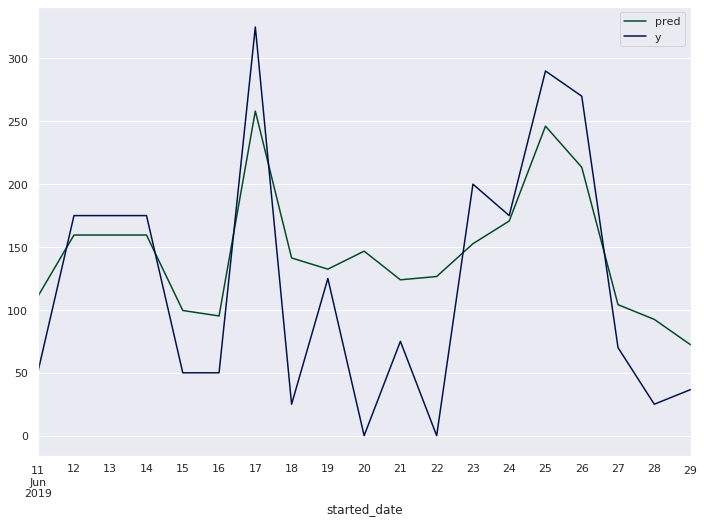

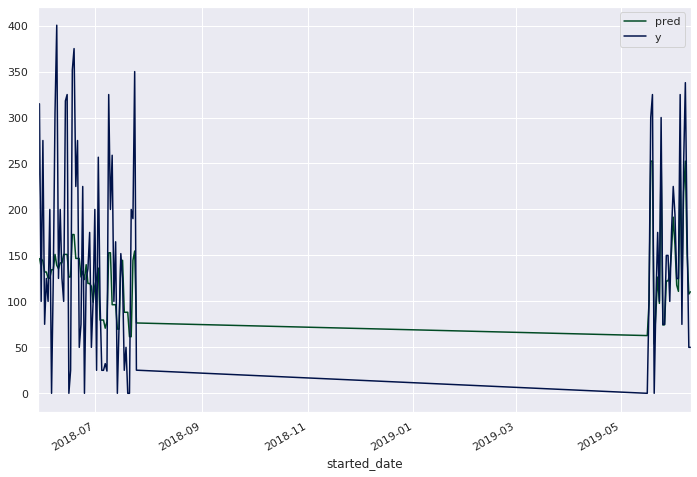

In [54]:
results_test.plot()
results_train.plot()
results.to_json("../pomo-process-frontend/src/assets/results.json")
scores.to_json("../pomo-process-frontend/src/assets/scores.json")